# Machine Learning

In this module we will see:

0. predictive models
1. classification
    1. logistic regression
    2. evaluation of classifiers
    3. k Nearest Neighbors
    4. multiclass classification
3. linear regression
4. data transformations
5. overfitting
6. regularization

In [147]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, ShuffleSplit, GroupKFold, StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib.patches import Patch
import seaborn as sns
import sys
sys.path.append('../../code/')
from utils_neuraldatascience import show_kFoldCV, plot_cv_indices

sns.set_context('talk')  # draws big plots
sns.set_palette('Set1')  # set the colormap for all plots

## Predictive models general framework
We are given some data points (or _samples_)

$x_1, x_2, \dots, x_N$

where each sample $x_i$ is a vector with $D$ _features_.

All samples are usually arranged in a, so called, _design matrix_ with samples on the raws and features on the columns:

$$
X = 
\begin{bmatrix}
x_{1,1} & x_{1,2} & \cdots & x_{1,D} \\
x_{2,1} & x_{2,2} & \cdots & x_{2,D} \\
\vdots  & \vdots  & \ddots & \vdots  \\
x_{N,1} & x_{N,2} & \cdots & x_{N,D} 
\end{bmatrix}
$$

We are also given a _label_ for each sample 

$y = [y_1, y_2, \dots, y_N]$

The goal is to build a model that, given a new sample from the population $x_i$ predicts as good as possible the label $y_i$.
The focus on prediction has important consequences for the evaluation of models as we will see shortly.

When the labels $y$ are continuous we have regression models, while when they are categorical we build classification models.


## Classification

In classification problems each sample $x_i$ is assigned to one class $C_k$. 
The (Bayes-)rational approach is to choose the class $C_k$ for which $p(C_k|x_i)$ is maximum.

### Logistic regression
This conditional probability cannot be calculated directly so a common approach is to assume a model for this probability. As usual we start with a linear model: 

$p(C_k|x) = \sigma(w^T x)$, where $\sigma$ is the logistic sigmoid function $\sigma(a) = \frac{1}{1+exp(-a)}$.

where $w$ is a vector of $D+1$ real coefficients (I follow the practice of absorbing the intercept into the vector $w$); thus the sigmoid function acts on a linear combination of the features of $x$. Due to the non linear function $\sigma(a)$ the model is actually not linear in the input $x$ or in the parameters $w$. However  

This model is called logistic regression. The name might sound confusing but if you think about it the model is actually just estimating the continuous probability $p(C_k|x)$; in order to classify we need to fix a value for $p(C_k|x)$ as a decision rule that is independent of the model.
Choosing the class that maximizes $p(C_k|x)$ is equivalent to fixing the decision rule at $p(C_k|x)=0.5$; this is a valid strategy only when the utility of each choice is equal. For example in a scenario of threat detection you generally place a higher cost on misses than on false alarms. But let's stick here to the simple case.

The reason why we call this a linear model for classification is that the decision boundary is linear in feature space (which is easily realized by noting that the boundary has equation $p(C_k|x) = \sigma(w^T x) = constant$ and this occurs when $w^T x = constant$).

The parameters $w$ are estimated by minimizing the (cross-entropy) error function (which arises from maximum-likelihood):
$$ E(w)= - \sum_i^N y_i ln\hat{y}_i + (1-y_i) ln(1-\hat{y}_i)$$

where $\hat{y}_i = \sigma(w^T x_i)$. I'm not entering into the details of the optimization but since the error function is concave there is only one minimum and efficient iterative methods can be used.

> __Note on other classification models__ 

>Other classifiers model the class conditional probability $p(x|C_k)$ and the prior class probability $p(C_k)$ and then use Bayes theorem to calculate the posterior class probability. Models of this family are linear and quadratic discriminant analysis and naive Bayes. In practice this classifiers have more parameters to estimate than simple linear regression and give poorer results when the assumptions behind their models are not met.

In order to understand how this model works, let's make up some data for classification:

In [148]:
def make_2Dclass(N=50, s1=1, s2=1, d=3):
    """ creates simple bidimensional data """
    Nhalf = int(N/2)
    x1 = np.random.randn(Nhalf, 2)*[s1, s2]
    x2 = np.random.randn(Nhalf, 2)*[s1, s2] + d
    X = np.vstack([x1, x2])
    y = np.array([0 if i<Nhalf else 1 for i in range(N)])
    return X, y

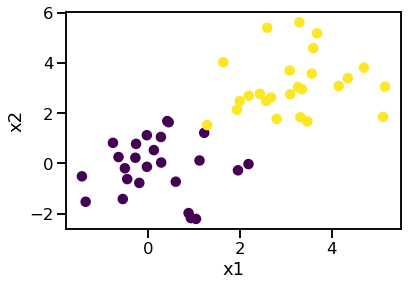

In [149]:
X, y = make_2Dclass(s1=1, s2=1, d=3)
# plot data
cm = plt.cm.RdBu
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

Now we can use scikit-learn library to implement a logistic regression model.

In [150]:
# define model
model = LogisticRegression(solver='lbfgs')

All scikit-learn model have a `fit()` method that allows to estimate their parameters. Since logistic regression is part of what is called __supervised learning__ we need to pass both X and y as parameters to `fit(X, y)`.

>__Supervised learning__ is a family of algorithm that uses information in the labels in order to estimate model's parameters; supervised methods are usually applied to classification and regression.

>__Unsupervised learning__, guess it, only uses information in $X$ to estimated model's parameters; typical tasks for unsupervised algorithms are clustering and dimensionality reduction.


In [151]:
# estimate parameters
model.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

We can also draw the boundary (since this is just 2D) and see how was the parameters estimation.

Since this is a linear model we know that the boundary is going to be a line with equation $u = \frac{w_1}{w_2} x_1 - \frac{w_0}{w_2}$, where $w$ is the vector of estimated coefficients and $w_0$ is the intercept.

Once a model has been fitted we can inspect the fitted coefficients through `coef_` and `intercept_` attributes (trailing underscore is the convention of scikit-learn for attributes that have been estimated).

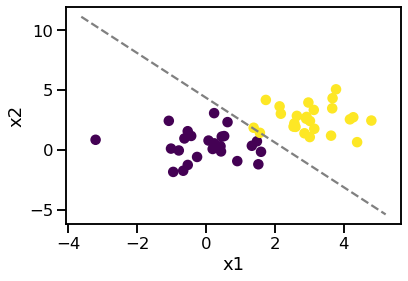

In [62]:
w = model.coef_[0]
xx = np.array([ax.get_xlim()[0], ax.get_xlim()[1]])
u = -w[0] / w[1] * xx - model.intercept_[0] / w[1]
plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, marker='o')
plt.plot(xx, u, '--', color='grey')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

You can play around creating data with different variance and different separation and see how the estimation is affected.

However when we talk about predictive models we usually want models that are able to make predictions for __new data__ that have not been used to estimate model's parameters, or in other words we want our model to be valid for the __population__ not only for the finite sample we have.

Since these are simulated data we can draw more samples and calculate the accuracy on these samples with model's parameters fixed.
This is achieved with `score()` method.

In [35]:
Xnew, ynew = make_2Dclass(N=100000, s1=1, s2=1, d=3)
print("acccuracy on new data: %.2f" %model.score(Xnew, ynew))

acccuracy on new data: 0.98


With real data we can't usually sample more points, so we need a procedure to test the accuracy of models for new samples (also called generalization accuracy) using only the data that we have.

### Classifiers evaluation

#### Training set has to be separated from test set

The data that we use to estimate model's parameters is called __training set__, so `X, y` above is our training set.

__test set__ is data that are only use to estimate prediction accuracy, `Xnew, ynew` above is our test set. 

What we want to know is how good the classifier is in predicting the class for the whole population, i.e. for future samples. 

So we have to evaluate the classifier on data that have not been used for training.

This means that we have to separate the available data in two sets: one for training and the other for testing.

The simplest way would be to split the samples in two sets, for example take the first 20% of samples for the test set and the rest for training.

In [36]:
N = X.shape[0]  # number of samples
n_test = int(N*0.2)  # num of samples for test set
# split the data
Xtest, ytest = X[:n_test, :], y[:n_test]
Xtrain, ytrain = X[n_test:, :], y[n_test:]
model.fit(Xtrain, ytrain)
print("test acccuracy: %.2f" %model.score(Xnew, ynew))

test acccuracy: 1.00


#### k-fold cross validation

If the number of samples is not really huge the noise in the specific chosen subset might give an estimate of generalization accuracy that is far from the true one.

An intuitive solution would be to repeat this procedure taking the second 20% of data for testing, then the third and so on. This method is called __k-fold cross-validation__.

k-fold cross-validation generates one partition of the dataset in k subsets, leaves one subset out, uses k-1 subsets to train the model and the one left out to test the trained model. This procedure is repeated until all subsets defined by the initial partion (also called folds) are used as test set. At the end k accuracies will be provided from which the median test-set accuracy can be calculated. k-fold CV requires more computations than a simple split but has the advantage of using all the data points available. The estimation accuracy is then improved. Typical values for `k` are between 3 and 10. The extreme case of `k=N`, where N is the number of all samples, is called __Leave-one-out CV__, since in each fold only one sample is left out for testing.

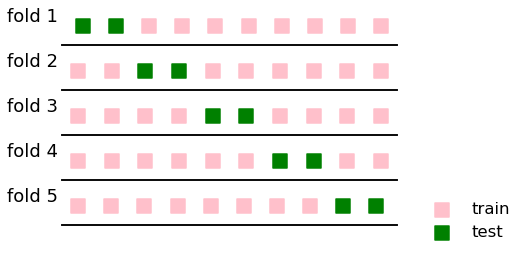

In [39]:
_, _ = show_kFoldCV(N=10, k=5)

Since here we train and test the model k times we will have k test accuracies. We can summarize the performance of our model as median or mean $\pm$ standard deviation.

In the following code I use `KFold` class from scikit-learn. This class, as others we are going to see, has a method `split()` that returns two lists of indices, one for training and one for testing.  

In [46]:
folds = 5
kf = KFold(n_splits=folds, shuffle=True)

score = np.zeros([folds])
i = 0  # counter for repetitions
for train_idx, test_idx in kf.split(X):  # repetitions loop
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i+=1

print("Test accuracy: %1.2f +/- %.2f (mean +/- standard deviation)" %(score.mean(), score.std()))     

Test accuracy: 0.98 +/- 0.04 (mean +/- standard deviation)


##### How many Folds?

So the question now is: how should I set the value of `k`?

We need to consider:

- number of samples in training set

    We want this to be as large as possible, since the more data the better the estimation of parameters


- number of samples in test set

    We want this to be large enough to have a stable estimate of test accuracy 


- number of splits (repetitions of training/test)

    We want this to be large enough to have a good estimate of median accuracy but not too large to avoid excess computation

#### Leave-one-out

At one extreme we have LOOCV with the largest possible training set (which is good) and as many splits as samples (which might be too much) and the smallest possible test set (which is not so good).

Indeed, typically LOOCV has high variance as an estimator of performance and is therefore not suggested. 

The following code shows that the variance of test accuracy increases as a function of k. Here I'm using scikit-learn function `make_classification()` that is a better and more general implementation than `make_2Dclass()`.

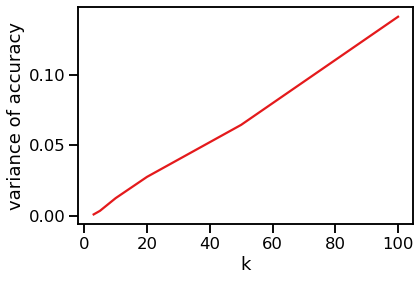

In [61]:
# show increase of variance with k
N = 100
X, y = make_classification(n_samples=N, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=0.4, random_state=8)

ks = [3, 5, 10, 20, 50, N]
var = np.zeros(len(ks))
# cross-validation
for j, k in enumerate(ks):
    shS = KFold(n_splits=k)
    score = np.zeros([k])
    i = 0
    for train_idx, test_idx in shS.split(X):
        data_train = X[train_idx, :]
        y_train = y[train_idx]
        data_test = X[test_idx, :]
        y_test = y[test_idx]
        clf = KNeighborsClassifier(n_neighbors=1).fit(data_train, y_train)
        score[i] = clf.score(data_test, y_test)
        i += 1
    var[j] = np.var(score)
plt.figure()
plt.plot(ks, var)
plt.xlabel('k')
plt.ylabel('variance of accuracy')
plt.show()

Smaller values of k give more stable estimate of test accuracy; in particular, in small datasets (~100 samples) values of k as small as 5 are suggested. However for very small datasets we mights actually want to highlight strong impact of choosing one or another sample as a test, so LOOCV is a good method in this case.

#### Shuffle and split

For small values of k we estimate the performance only on few splits. If we want a more stable estimation of prediction accuracy we can rely on a different method based on random permutations. With this method we leave out a random selection of samples of a given size `test_size` for the test set and use all other samples for training. This procedure can be repeated many times. The method is also called __shuffle & split__, since data can be first shuffled and then split into training and test set.

The advantage with respect to k-fold CV is that here the number of splits and test set size are decoupled: we can repeat the splitting as many times as we want independently of the number of samples used for training and testing.

In the following code I used scikit-learn class `ShuffleSplit` that implements random permutation CV. Now we have `repetitions` splits, so instead of just summarizing the accuracy with its median or mean we can have a look at its distribution using a violing plot implemented in seaborn library. When the accuracy approaches the extremes of 1 or chance level the distribution gets very skewed.

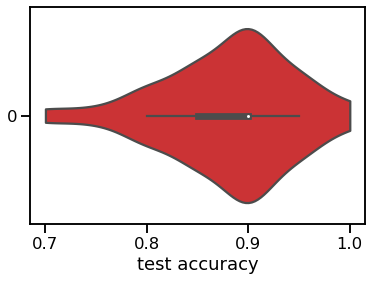

In [62]:
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i += 1

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score], cut=0, orient='h', scale='width', ax=ax)
ax.set_xlabel('test accuracy')
plt.show()

#### How good is the obtained accuracy?

In order to answer this question we need to compare our accuracy with that expected by chance, i.e. by purely guessing the prediction.

In a simple case if we have two classes with the same number of elements we know that by guessing we are going to right 50% of the times (we can even estimate the variance of random guessing strantegy modelling it as a Binomial distribution).

As an alternative, that also works in more complicated scenarios, we can shuffle the labels in `y`, thereby destroying the relation between `X` and `y`, and train another classification model on this shuffled data. The resulting test accuracy will be that expected by chance.

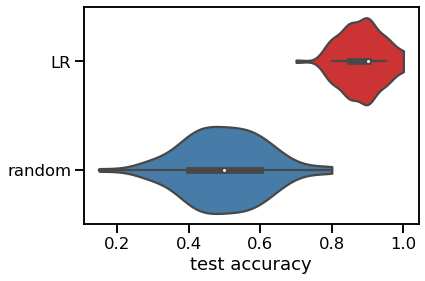

In [68]:
# instantiate a model for random guessing
model_rnd = LogisticRegression(solver='lbfgs')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    # randomly shuffle labels
    y_rnd = np.random.permutation(y)
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'random'])
ax.set_xlabel('test accuracy')
plt.show()

#### Unbalanced classes

When we have unbalanced classes the expected number of correct random guesses is higher.

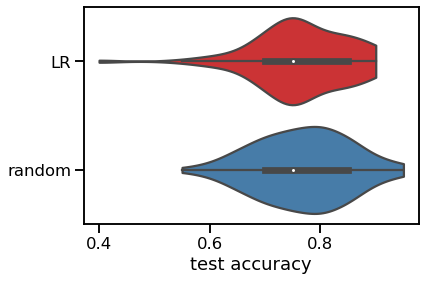

In [70]:
# create data with 80% of samples in one class
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.8, 0.2], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
# instantiate a model for random guessing
model_rnd = LogisticRegression(solver='lbfgs')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    # randomly shuffle labels
    y_rnd = np.random.permutation(y)
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'random'])
ax.set_xlabel('test accuracy')
plt.show()

#### Sensitivity and specificity

Classification accuracy is not the only measure to assess model's performance.
Some times the two classes we are predicting have very different meaning, as in the example above of threat detection.
In such cases is more interesting to look at the two different types of errors (in binary classification).\

The error of classifying a threat as non-threat (or cancer as non-pathological) is called a __miss__ or __type II error__.
Classifying a normal medical image as cancer is called a __false alarm__ or __type I error__.

Its practical to represent this information in a so called __confusion matrix__ where, in each entry $C_{i,j}$ we have the proportion of samples from class $i$ predicted by the model as class $j$.

Thus on the diagonal we have correct predictions, in $C_{1,2}$ we have false alarms and in $C_{2,1}$ there are the misses.

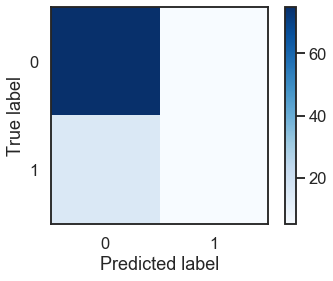

In [71]:
CM = confusion_matrix(y_true=y, y_pred=model.predict(X))
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(CM, cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks([0, 1], [0, 1])
    plt.yticks([0, 1], [0, 1])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#### CV for grouped observations

There are other other two CV strategy that you should be aware of for more complex scenarios: stratified and grouped cross-validation.

When you stratify the folds of your CV in each fold you get the same proportion of each class as in the whole dataset. This is useful for example when the classes are unbalanced, so that each fold reflects the exact proportion of samples in each class.

When your data have an additional grouping beyond that of the classes you want to predict it's important to use CV for grouped observations in order to get a fair test accuracy. Indeed, using standard k-fold or permutation CV the additional grouping will presumably produce test sets that are highly correlated with the training set. CV for grouped observations excludes from the training whole groups of samples so that in the test set and training set are not anymore correlated.

The following code illustrates the difference between CV strategies.

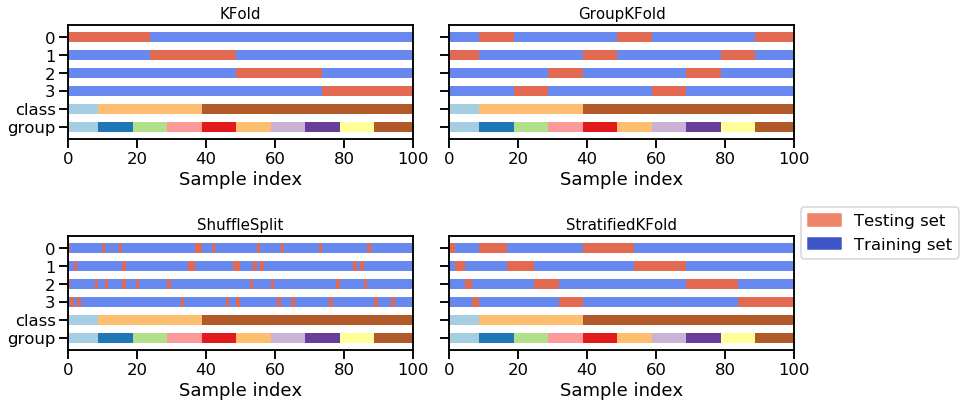

In [146]:
# Generate the class/group data
n_points = 100
X = np.random.randn(100, 10)
percentiles_classes = [.1, .3, .6]
y = np.hstack([[ii] * int(100 * perc)
               for ii, perc in enumerate(percentiles_classes)])
# Evenly spaced groups repeated once
groups = np.hstack([[ii] * 10 for ii in range(10)])

cmap_cv = plt.cm.coolwarm
n_folds = 4
cvs = [KFold, GroupKFold, ShuffleSplit, StratifiedKFold]

fig, ax = plt.subplots(figsize=(16, 6), nrows=2, ncols=2, sharey=True)
for i, cv in enumerate(cvs):
    ri = int(i/2)
    rc = i%2
    this_cv = cv(n_splits=n_folds)
    plot_cv_indices(this_cv, X, y, groups, ax[ri, rc], n_folds)

    if i==3:
        ax[ri, rc].legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
                  ['Testing set', 'Training set'], loc=(1.02, .8))
    yticklabels = list(range(n_folds)) + ['class', 'group']
    ax[ri, rc].set(yticks=np.arange(n_folds+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index',
           ylim=[n_folds+2.2, -.2], xlim=[0, 100])
    # Make the legend fit
    plt.tight_layout()
    fig.subplots_adjust(right=.7)
plt.show()

### <font color="blue"> Exercises

1. change the separation between the two classes in order to see how it affects the classification performance
2. increase the number of samples. How does it affect the classification? (use make_classification() to generate data).
3. increase the number of dimension for the data. How is the accuracy affected? How many samples do you need to get the same level of accuracy?
4. try different proportions of samples for each class to see how the inbalance affects the classifcation (through a confusion matrix)
5. show the confusion matrix for the test set of one cross-validation fold.
6. $\star$ show the average confusion matrix for the test set over all folds.
7. modify the code of confusion matrix to show the proportion of samples with respect to the number of samples in each class.

### k Nearest Neighbors

Logistic regression is going to produce prediction errors when the classes are __not linearly separable__.

Let make up some bidimensional data with the typical XOR structure.

In [13]:
def make_nonlin_classification(N=100, s1=1, s2=1, d=3):
    """ creates bidimensional non linearly separable (XOR) classification data """
    Nblob = int(N/4)
    x1a = np.random.randn(Nblob, 2)*[s1, s1]
    x2a = np.random.randn(Nblob, 2)*[s2, s2] + [0, d]
    x1b = np.random.randn(Nblob, 2)*[s2, s2] + [d, d]
    x2b = np.random.randn(N-3*Nblob, 2)*[s2, s2] + [d, 0]
    X = np.vstack([x1a, x1b, x2a, x2b])
    y = np.array([0 if i<Nblob*2 else 1 for i in range(N)])
    return X, y

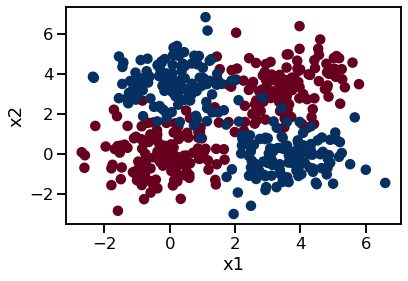

In [80]:
X, y = make_nonlin_classification(N=500, s1=1, s2=1, d=3.5)
# plot data
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

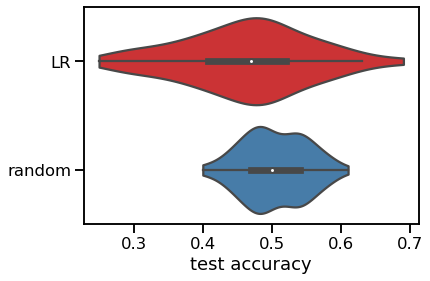

In [64]:
# instantiate a model for random guessing
model = LogisticRegression(solver='lbfgs')
model_rnd = LogisticRegression(solver='lbfgs')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    # randomly shuffle labels
    y_rnd = np.random.permutation(y)
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig2, ax2 = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax2)
ax2.set_yticklabels(['LR', 'random'])
ax2.set_xlabel('test accuracy')
plt.show()

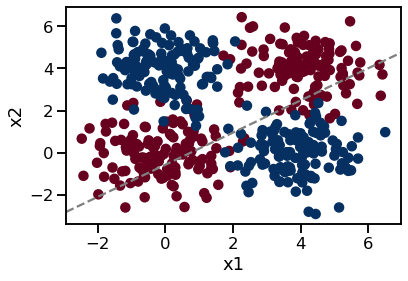

In [65]:
w = model.coef_[0]
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.array([xlim[0], xlim[1]])
u = -w[0] / w[1] * xx - model.intercept_[0] / w[1]
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, marker='o')
plt.plot(xx, u, '--', color='grey')
plt.xlabel('x1')
plt.ylabel('x2')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
plt.show()

In this situation other models, able to draw a non linear decision boundary, are going to produce a better solution.

A simple non linear classifier is the so called __k nearest neighbors__ (kNN).

For each new sample in the test set $X_i$ kNN looks for the $k$ nearest samples (according to a defined metric, usually euclidean distance) in the training set and assigns to $X_i$ the class that has the largest count among the $k$ neighbors (braking ties at random).

Thus kNN has no parameters (it is often called a model-free classifier) and only needs to _memorize_ the training set (indeed it's inpractical for huge datasets).

If we change the model in the above code to use kNN we get a good accuracy.

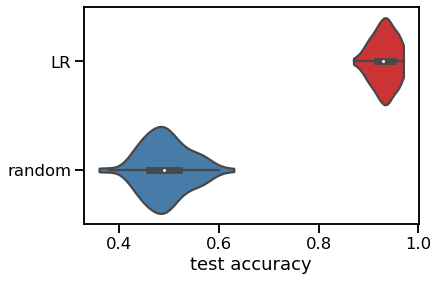

In [87]:
# instantiate a model for random guessing
model = KNeighborsClassifier(n_neighbors=10)
model_rnd = KNeighborsClassifier(n_neighbors=10)
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_rnd = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    # randomly shuffle labels
    y_rnd = np.random.permutation(y)
    model_rnd.fit(X[train_idx, :], y_rnd[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    score_rnd[i] = model.score(X[test_idx, :], y_rnd[test_idx])
    i += 1
    
# plot comparison as violin plots
sns.set_context('talk')
fig2, ax2 = plt.subplots(nrows=1, ncols=1, sharex=True)
sns.violinplot(data=[score, score_rnd], cut=0, orient='h', scale='width', ax=ax2)
ax2.set_yticklabels(['LR', 'random'])
ax2.set_xlabel('test accuracy')
plt.show()

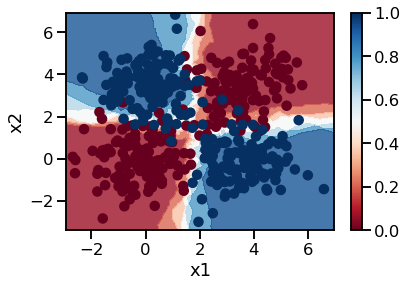

In [88]:
fig, ax = plt.subplots()
h = 0.02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm, marker='o')
plt.xlabel('x1')
plt.ylabel('x2')
ax.set_ylim(ylim)
ax.set_xlim(xlim)
plt.colorbar()
plt.show()

> There are many other non linear models for classification that we can't cover here. You may want to have a look at __support vector machines__ that crudely speaking are able to fit a linear model to a non linear transformation of the data.

### <font color="blue"> Exercises

1. try different values of `k`. How does the decision boundary and accuracy vary?
2. change the degree of overlap of the two classes and try classification with different values of `k`.

_(Hint) For `k=1` the boundary correspond to the so called Voronoi tassellation of the training set, thus all samples in the training set are perfectly predicted_

### Multiple classes

Until now we only worked with binary classification but many interesting problems have several classes. For example distinguishing AD from MCI and controls or characterizing different cognitive tasks or identifying individual subjects (brain-fingerprinting).

Every binary classifier can be used to classify samples from multiple classes by transforming a problem with $k$ classes in $k$ binary classification of one class against all the rest of classes. Unexpectedly this method is called _one versus the rest_.

Some classifiers however are natively multiclass, like kNN and don't need to rely on one-versus-rest heuristics. Logistic regression has its multiclass version, _multinomial_ logistic regression, where the logistic sigmoid is replaced by the softmax function $\psi(a_i) = \frac{exp(a_i)}{\sum^k_j exp(a_j)}$.

When we have multiple classes the most useful tool for the assessment of model's performance is again the confusion matrix. Indeed, as you can see in the following code, the confusion matrix immediately informs us about any inbalance in the accuracy. In practive you will often observe that some class is particularly difficult or particularly easy to predict.

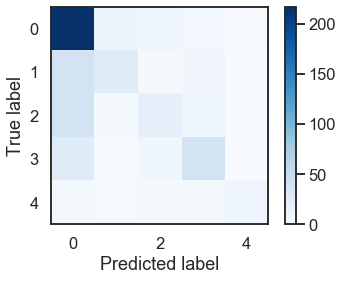

In [4]:
# create data with multiple classes
X, y = make_classification(n_samples=500, n_features=10, n_informative=10,
                           n_redundant=0, n_repeated=0, n_classes=5,
                           weights=[0.5, 0.15, 0.15, 0.15, 0.05], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])
    i += 1

CM = confusion_matrix(y_true=y, y_pred=model.predict(X))
with sns.axes_style('white'):
    plt.figure()
    plt.imshow(CM, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Regression

I want to just briefly mention regression problems. We need a regression model when the variable to be predicted `y` is continuous. For example you may want to predict score of a subject in a cognitive task or neuropsycological assessment.

A simple synthetic example is the following.

In [42]:
def make_gauss_regression(N=50, s=1, eps=0.1):
    X = np.random.randn(N, 1) * s
    y = X + np.random.randn(N, 1) * eps
    return X, y

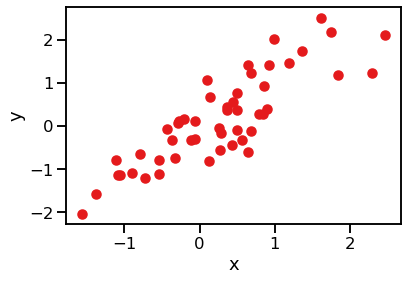

In [58]:
X, y = make_gauss_regression(eps=.5)
plt.figure()
plt.scatter(X, y)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In this case we see that a linear model is a good fit for the problem: $$ y = w^T x $$

This model is implemented in scikit-learn `LinearRegression` object.

In [59]:
model = LinearRegression()
folds = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
for i, (train_idx, test_idx) in enumerate(shS.split(X)):  # repetitions loop
    model.fit(X[train_idx, :], y[train_idx])
    score[i] = model.score(X[test_idx, :], y[test_idx])

While we evaluate classifiers counting the number of correct predictions, in regression the error is also of continuous nature, so we need a different scoring function. The most used one is the $R^2$ or coefficient of determination, which represents the fraction of variance in data explained by the model:
$$ R^2 = 1 - \frac{\sum^N_i (y_i-\hat{y}_i)^2}{\sum^N_i (y_i-\bar{y})^2}$$

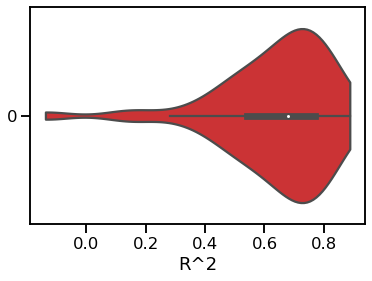

In [60]:
fig, ax = plt.subplots()
sns.violinplot(data=[score], cut=0, orient='h', scale='width')
ax.set_xlabel(r'R^2');

### <font color="blue"> Exercises

1. try different levels of noise in the data to see how the $R^2$ changes.

## Data transformations

Until now we have seen simple classification based on "raw" data. Actually it is common to apply some transformations to data in order to boost the performance of the classifier.

Typical transformations for general applications include (but are not limited to) normalization and dimensionality reduction. But if you think about neuroscience also calculating the functional connectivity is a kind of transformation: you are given time series and you transform them into a connectivity matrix. Even before that parcellating the signals is a kind of transformation.

Many transformation involve some parameter fitting (estimation of EC, functional parcellations, standardization).

__WARNING__: It's very important that, if the estimation of parameters need to use information from multiple samples, the only samples used are those from the training set (not the whole dataset). Always remember that you are not supposed to have access to the test set until the training of your predictive model is done, you can think about the test set as data that will be aquired in the future; so, using the test set for estimating any transformation is like __looking into the future__.

So, for example, if you use a functional parcellation that estimate clusters of time series over all subjects, you need to estimate the clusters only using the subjects from the training set and then apply the clustering to the subjects of the test set. 

As an example, here we see how to perform a simple standardization of data (which is useful when features have different scales). For this we go back to classification.

> If you need to perform data transformations scikit-learn has a nice mixin class `TransformerMixin` that allows to easily create transformers (I'm not covering this but you can read more in scikit-learn docs).

In the following code we compare a raw dataset with its standardized version. In order to standardize data we use scikit-learn `StandardScaler` class, that is a transformer, thus it implements a `transform()` method.

In [18]:
X, y = make_2Dclass(N=50, s1=.1, s2=40, d=.4)
scaler = StandardScaler()
Xscaled = scaler.fit_transform(X)

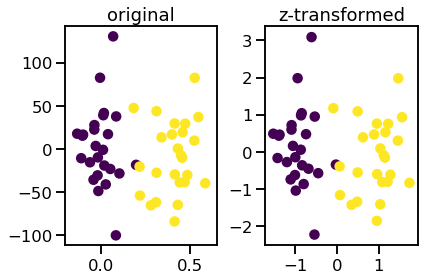

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(X[:, 0], X[:, 1], c=y, marker='o')
ax[0].set_title('original')
ax[1].scatter(Xscaled[:, 0], Xscaled[:, 1], c=y, marker='o')
ax[1].set_title('z-transformed')
plt.tight_layout()

Scikit-learn implements the concept of a pipeline to connect several estimators in the class `Pipeline`, which are as you can imaging objects that make some estimation. You can connect as many transformers as you wish in a pipeline and the last step may be a transformer or a classifier.

In the following code we build a pipeline with a `StandardScaler` and `LogisticRegression` model and compare the classification accuracy with that of the simple logistic regression.

Notice that estimating parameters for the z-score only on training set and applying them to transform the test set is done by the pipeline under the hood: when we call the `fit()` method of the pipeline we only pass the training set and all the parameters in the pipeline are estimated only using these data. So, if we use a pipeline we don't need to put extra effort to keep training and test separated, scikit-learn is doing it for us.

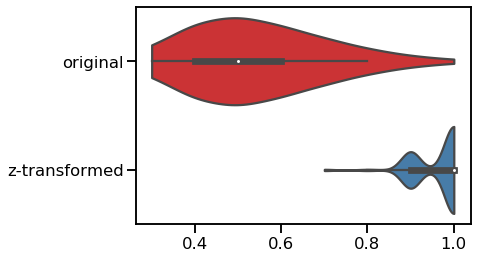

In [20]:
model = LogisticRegression(solver='lbfgs')
pipe = Pipeline([('clf', model)])
pipeS = Pipeline([('zscore', StandardScaler()), 
                         ('clf', model)])
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)

score = np.zeros([repetitions])
scoreS = np.zeros([repetitions])
i = 0  # counter for repetitions
for train_idx, test_idx in shS.split(X):  # repetitions loop
    pipe.fit(X[train_idx, :], y[train_idx])
    pipeS.fit(X[train_idx, :], y[train_idx])
    score[i] = pipe.score(X[test_idx, :], y[test_idx])
    scoreS[i] = pipeS.score(X[test_idx, :], y[test_idx])
    i+=1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[score, scoreS], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['original', 'z-transformed'])
plt.show()

Beyond allowing to show the usefulness of `Pipeline` this example also shows the importance of scaling features when they are not homogeneous: __if a non informative feature has large variance you are going to have poor accuracy__.

## Overfitting

When models are too complex (too many degrees of freedom) compared to the constraints imposed by data they tend to _overfit_, i. e. perfectly adjust to the training data, thereby fitting the noise, which in turn produces low performance on new data (where the noisy realizations are different).

We see here an example of overfitting for kNN classifier where a small value of $k$ gives a more complex model (think about how the decision boundary changes when $k$ is changed).

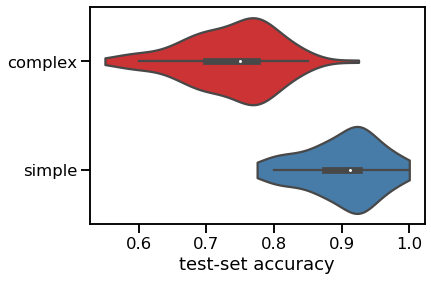

In [61]:
X, y = make_classification(n_samples=200, n_features=50, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=0.9, random_state=None)
# models
clf_complex = KNeighborsClassifier(n_neighbors=1)
clf_simple = KNeighborsClassifier(n_neighbors=50)
# cross-validation
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=0)
scoreC = np.zeros([repetitions])
scoreS = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    clf_complex.fit(X[train_idx, :], y[train_idx])
    clf_simple.fit(X[train_idx, :], y[train_idx])
    scoreC[i] = clf_complex.score(X[test_idx, :], y[test_idx])
    scoreS[i] = clf_simple.score(X[test_idx, :], y[test_idx])
    i += 1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[scoreC, scoreS], cut=0, orient='h', scale='width')
ax.set_yticklabels(['complex', 'simple'])
ax.set_xlabel('test-set accuracy')
plt.show()


In practice if you get a poor prediction accuracy it's not easy to tell if your model is wrong or if you are overfitting data.

In order to distinguish the two cases you should compare training and test accuracy. In extreme cases we get zero error on the training set (the model perfectly predicts the training set) and higher error on the test set.

In our example we don't even need to calculate the training accuracy since we already know that with `k=1` the error on the training set is zero.

### Overfitting in high dimensions

Overfitting is often observed when the data have many dimensions (which is a common situation in neuroscience), compared to the number of samples.

Notice that 3 points in 2D space are always linearly separable (and more in general N points in the N-1 dimensional space). To get an intuition you can think about the process of doing a polynomial regression adding many terms: at some point the polynomial has enough degrees of freedom to exactely pass through all the points but it's not capturing the true relation in the data. Something similar happens when your data have too many dimensions.

We see it in practice in the following code.

In [78]:
D = 100
X, y = make_classification(n_samples=100, n_features=D, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
clf = LogisticRegression(solver='lbfgs', C=10000, penalty='l2')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
score = np.zeros([repetitions])
score_train = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    clf.fit(X[train_idx, :], y[train_idx])
    score[i] = clf.score(X[test_idx, :], y[test_idx])
    score_train[i] = clf.score(X[train_idx, :], y[train_idx])
    i += 1

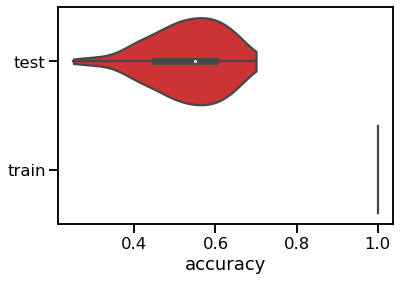

In [79]:
# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[score, score_train], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['test', 'train'])
ax.set_xlabel('accuracy')
plt.show()

## Regularization

Regularization is a family of techniques to reduces the complexity of a model and so avoid overfitting.

Here I'm only showing regularization for logistic regression. In this case in order to regularize the estimation we can simply add a penalty term to the error function $E(w)$.

$$E_{reg}(w) = E(w) + \lambda ||w||_q$$

where $||w||_q = (\sum^D_j(w_j^q))^{\frac{1}{q}}$ is the q-norm of the weights vector and $\lambda$ is a scalar penalty parameter. In practice only 1- and 2-norm are used.

As you can intuitively see a high value of $\lambda$ will push all coefficients in $w$ to zero (since we are minimizing the error function. If $\lambda=0$ we recover the unregularized estimation. The difference between 1- and 2-norm is only the speed at which coefficients are pushed to zero, thus 1-norm promotes sparser solutions (more coefficients are estimated as zero) than 2-norm.

In the following code we can compare an L2-regularized logistic regression with the unregularized one. 
Here we are using 1-norm since we know that many features are not informative at all. Scikit-learn implementation has parameter `C` which correspond to $1/\lambda$). 

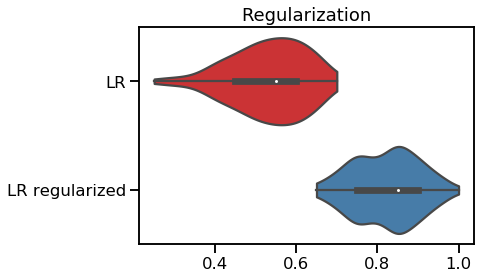

In [82]:
D = 100
X, y = make_classification(n_samples=100, n_features=D, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           weights=[0.5, 0.5], n_clusters_per_class=1,
                           class_sep=0.5, random_state=0)
clfreg = LogisticRegression(C=.1, penalty='l1', solver='liblinear')
repetitions = 100
shS = ShuffleSplit(n_splits=repetitions, test_size=0.2, random_state=None)
scorereg = np.zeros([repetitions])
i = 0
for train_idx, test_idx in shS.split(X):
    clfreg.fit(X[train_idx, :], y[train_idx])
    scorereg[i] = clfreg.score(X[test_idx, :], y[test_idx])
    i += 1

# plot comparison as violin plots
fig, ax = plt.subplots(nrows=1, ncols=1)
sns.violinplot(data=[score, scorereg], cut=0, orient='h', scale='width', ax=ax)
ax.set_yticklabels(['LR', 'LR regularized'])
ax.set_title('Regularization')
plt.show()

### <font color="blue"> Exercises

1. try different values of the penalty parameter $C$.
2. vary the number of features.
3. try L1 or L2 regularization.